<a href="https://colab.research.google.com/github/dennisvictoria/SeniorResearch2023/blob/main/PartTwo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#description: classify images

In [78]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import keras.backend as hist

from tensorflow.keras import layers
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import PIL
import PIL.Image
import tensorflow as tf
plt.style.use('fivethirtyeight')

In [16]:
##Loading Data
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/seven_plastics')

Mounted at /content/drive


In [17]:
data_dir = pathlib.Path('/content/drive/MyDrive/seven_plastics')
count = len(list(data_dir.glob('*/*.jpg')))
print(count)

429


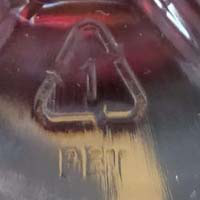

In [18]:
##Loading Images
onepoly = list(data_dir.glob('polyone/*'))
PIL.Image.open(str(onepoly[5]))


In [19]:
##Creating the dataset
batch_size = 32
img_height = 200
img_width = 200

In [20]:
##validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split= 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split= 0.2,
    subset ="validation",
    seed = 123,
    image_size=(img_height, img_width),
  batch_size=batch_size)

Found 429 files belonging to 8 classes.
Using 344 files for training.
Found 429 files belonging to 8 classes.
Using 85 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['2_high_density_polyethylene_PE-HD', '3_polyvinylchloride_PVC', '4_low_density_polyethylene_PE-LD', '5_polypropylene_PP', '6_polystyrene_PS', '7_other_resins', '8_no_plastic', 'polyone']


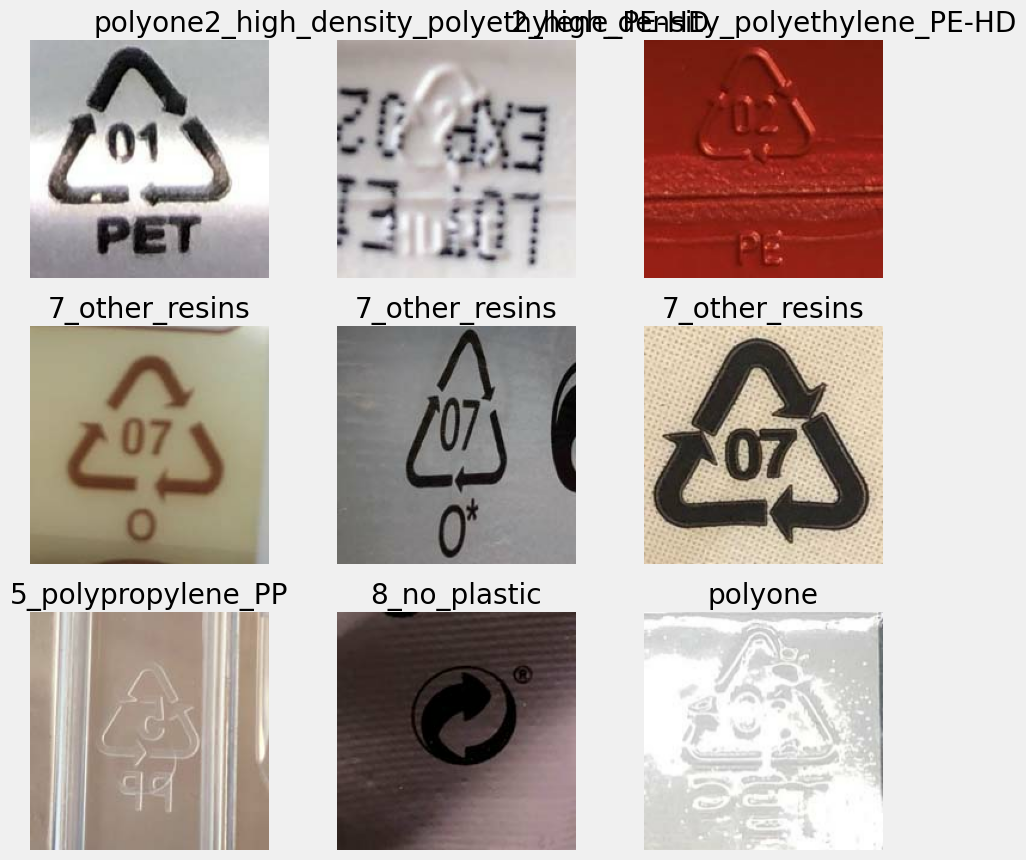

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [23]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.10196079 0.9843138


In [24]:
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE
##normalization

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [30]:
from keras import Model
##Training the Model
num_classes = 8

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])



In [79]:
def f1_metric(y_true, y_pred):
    true_positives = hist.sum(hist.round(hist.clip(y_true * y_pred, 0, 1)))
    possible_positives = hist.sum(hist.round(hist.clip(y_true, 0, 1)))
    predicted_positives = hist.sum(hist.round(hist.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + hist.epsilon())
    recall = true_positives / (possible_positives + hist.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+hist.epsilon())
    return f1_val


model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy', f1_metric])

hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
11/11 [==============================] - 14s 1s/step - loss: 1.0409 - accuracy: 0.6890 - f1_metric: 1.8058 - val_loss: 2.3037 - val_accuracy: 0.3412 - val_f1_metric: 1.7864
Epoch 2/10
11/11 [==============================] - 12s 1s/step - loss: 0.8277 - accuracy: 0.7093 - f1_metric: 1.7519 - val_loss: 2.6410 - val_accuracy: 0.3176 - val_f1_metric: 1.6837
Epoch 3/10
11/11 [==============================] - 13s 1s/step - loss: 0.6195 - accuracy: 0.7674 - f1_metric: 1.6980 - val_loss: 2.7937 - val_accuracy: 0.3765 - val_f1_metric: 1.6327
Epoch 4/10
11/11 [==============================] - 13s 1s/step - loss: 0.5063 - accuracy: 0.8343 - f1_metric: 1.6505 - val_loss: 2.6652 - val_accuracy: 0.3412 - val_f1_metric: 1.6366
Epoch 5/10
11/11 [==============================] - 13s 1s/step - loss: 0.4362 - accuracy: 0.8576 - f1_metric: 1.6277 - val_loss: 3.6791 - val_accuracy: 0.2824 - val_f1_metric: 1.6129
Epoch 6/10
11/11 [==============================] - 13s 1s/step - loss: 0.3701 -

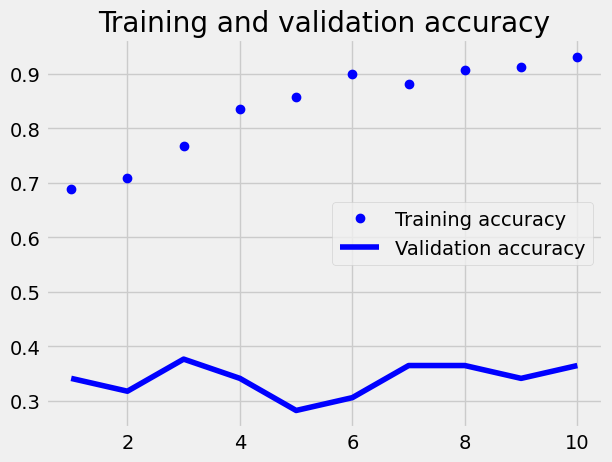

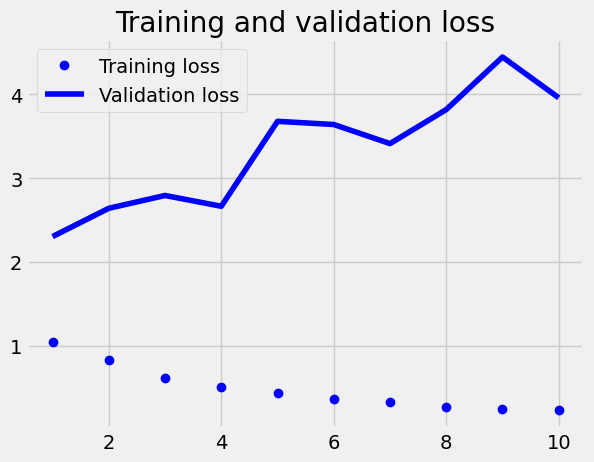

In [80]:
accuracy= hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
##grain control: attempt ???

In [73]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(count, reshuffle_each_iteration=False)

In [74]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/drive/MyDrive/seven_plastics/7_other_resins/IMG_6554.jpg'
b'/content/drive/MyDrive/seven_plastics/7_other_resins/IMG_E6462.jpg'
b'/content/drive/MyDrive/seven_plastics/5_polypropylene_PP/IMG_6339.jpg'
b'/content/drive/MyDrive/seven_plastics/8_no_plastic/IMG_9746.jpg'
b'/content/drive/MyDrive/seven_plastics/6_polystyrene_PS/IMG_6525.jpg'


In [75]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['2_high_density_polyethylene_PE-HD' '3_polyvinylchloride_PVC'
 '4_low_density_polyethylene_PE-LD' '5_polypropylene_PP'
 '6_polystyrene_PS' '7_other_resins' '8_no_plastic' 'polyone']


In [47]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

11
3


In [ ]:
#Configuring Datasets

In [48]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size = 1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size = AUTOTUNE)
  return ds

  train_ds = configure_for_performance(train_ds)
  val_ds = configure_for_performance(val_ds)

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        9

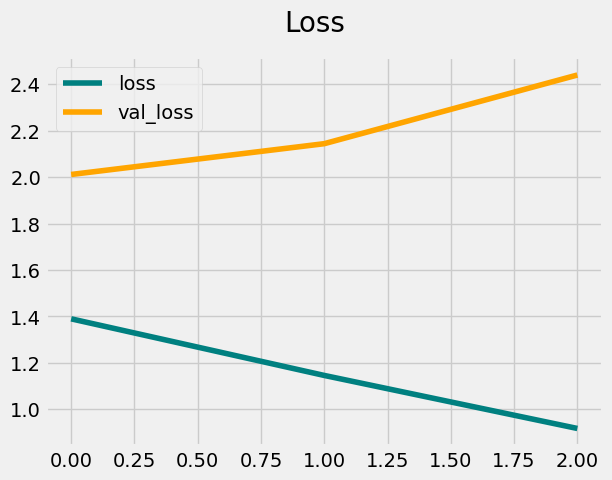

In [76]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

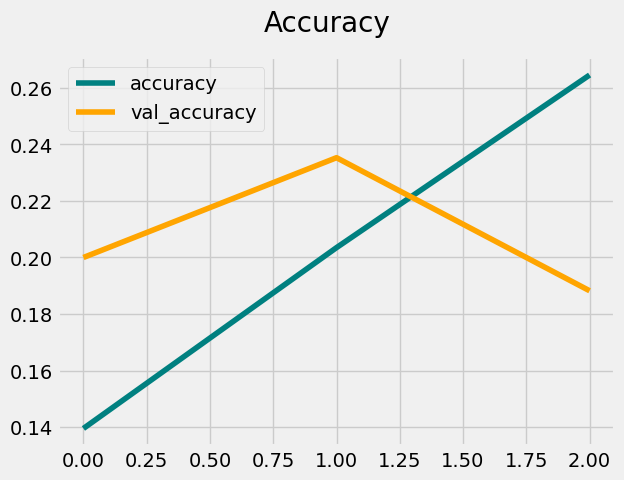

In [51]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()